In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [127]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize(64),
            transforms.RandomAdjustSharpness(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
data = datasets.ImageFolder(root='../lab3data', transform=None)
data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.7 * len(data))
val_split = math.ceil(0.15 * len(data))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)


TypeError: __init__() missing 1 required positional argument: 'sharpness_factor'

In [128]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        data = np.array(in_data)
        self.input_dirs = data[:, 0]
        self.labels = data[:, 1]
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, transformed, labels
        else:
            return inputs, inputs, labels

In [129]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_list[train.indices], transform=(transform, transform))
    val_data = GenData(data_list[val.indices], transform=(transform, transform))
    test_data = GenData(data_list[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader



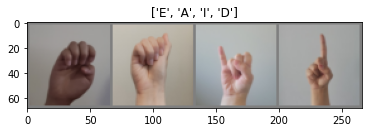

In [134]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(4)
inputs, _, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x.item()] for x in classes])

In [135]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENet(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENet, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 100

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3), # 224 --> 72 = (224 + 0 - 11)/3 + 1
            nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1), # 24 --> 24 = (24 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # 11 --> 11 = (10 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

        )

        self.muFC = nn.Linear(5 * 5 * 256, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 256, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 256)

        self.back = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, padding=0, stride=2, output_padding=1), # 11 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=3, padding=0, stride=3, output_padding=0), # 24 -> 72
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 72 -> 224
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 256)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 256, 5, 5)

        x = self.back(x)
        x = F.softmax(x, 0)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [136]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENetSmall(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENetSmall, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 256

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=36, kernel_size=11, stride=3), # 224 --> 40 = (128 + 0 - 11)/3 + 1
            # nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=36, out_channels=64, kernel_size=3, padding=1, stride=2), # 40 --> 20 = (40 + 2 - 3)/2 + 1
            # nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2), # 20 --> 10 = (20 + 2 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2), # 10 --> 5 = (10 + 2 - 3)/1 + 1
            # nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),

        )

        self.muFC = nn.Linear(5 * 5 * 64, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 64, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 64)

        self.back = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1), # 5 -> 10
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1), # 10 -> 20
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2, output_padding=1), # 20 -> 40
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 40 -> 128
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 64)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 64, 5, 5)

        x = self.back(x)
        x = F.softmax(x)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [137]:
from torchsummary import summary

model = VAENetSmall()
model.to('cuda:0')

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 36, 40, 40]          13,104
              ReLU-2           [-1, 36, 40, 40]               0
       BatchNorm2d-3           [-1, 36, 40, 40]              72
           Dropout-4           [-1, 36, 40, 40]               0
            Conv2d-5           [-1, 64, 20, 20]          20,800
              ReLU-6           [-1, 64, 20, 20]               0
       BatchNorm2d-7           [-1, 64, 20, 20]             128
           Dropout-8           [-1, 64, 20, 20]               0
            Conv2d-9          [-1, 128, 10, 10]          73,856
             ReLU-10          [-1, 128, 10, 10]               0
      BatchNorm2d-11          [-1, 128, 10, 10]             256
          Dropout-12          [-1, 128, 10, 10]               0
           Conv2d-13             [-1, 64, 5, 5]          73,792
             ReLU-14             [-1, 6

C:\Users\ammar\AppData\Local\Temp\ipykernel_25564\2234998305.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [138]:
'''
Loss function
'''

def vaekl_loss(recon_x, x, mu, logvar, batch_size):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 3 * 128 * 128
    return kld

In [139]:
'''
Helper functions (based off of previous labs)
'''

def calculate_error(inputs, target):
    difference = torch.abs(target - inputs)
    mean_error = torch.mean(difference, dim=-1) # mean along width
    mean_error = torch.mean(mean_error, dim=-1) # mean along height
    mean_error = torch.mean(mean_error, dim=-1) # mean along channel

    # print(difference.size())
    # print(mean_error.size())
    # print(mean_error)

    return mean_error.sum()  


def evaluate(model, loader, criterion, cuda=False, batch_size=64, alex=False):
    '''
    Function to evaluate the model's performance on a val/test set
    '''


    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, transformed, labels = data

        ########## SENDING TO CUDA ############
        if cuda:
            inputs = inputs.to('cuda:0')
            transformed = transformed.to('cuda:0')
            
        

        outputs, latent_vector, mu, logvar = model(transformed)

        if alex:
            labels = labels.squeeze(1)

        # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
        loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=1000)['loss']


        # Find the mean error over the image
        output_err = calculate_error(outputs, inputs) 

        total_err += output_err
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [140]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(model, batch_size=32, lr=0.005, momentum=0.9, num_epochs=30, cuda=True, loader=None, alex=False, sheduler=False):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Get the dataloaders with respective batch size
    train_dl, val_dl, _ = get_data_loaders(batch_size=batch_size)

    # Criterion and optimizer
    criterion = nn.MSELoss()
    # optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    optimizer =  optim.Adam(model.parameters(), lr=lr)

    if sheduler:
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)



    # Training metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        model = model.to('cuda:0')

    start_time = time.time()
    model.train()

    # Train loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_dl if not loader else loader):

            inputs, transformed, labels = data


            ########## SENDING TO CUDA ############
            if cuda:
                inputs = inputs.to('cuda:0')
                transformed = transformed.to('cuda:0')

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs, latent_vector, mu, logvar = model(transformed)

            if alex:
                labels = labels.squeeze(1)

            # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
            loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=1000)['loss']
            loss.backward()
            optimizer.step()

            # Find the mean error over the image
            output_err = calculate_error(outputs, inputs)

            total_train_err += output_err
            total_train_loss += loss.item()
            total_epoch += len(labels)

        if sheduler:
            exp_lr_scheduler.step()

        train_err[epoch] = float(total_train_err) / (total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_dl if not loader else loader, criterion, cuda, batch_size, alex)

        tqdm.tqdm.write(f'Epoch {epoch}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}')

        # Check whether a better train/val err has been found
        better = False
        if train_err[epoch] < best_train_err:
            best_train_err = train_err[epoch]
            better = True
        if val_err[epoch] < best_val_err:
            best_val_err = val_err[epoch]
            better = True

        if better or epoch == (num_epochs - 1):
            model_path = OUTPUT_DIR + get_model_name(model.name, batch_size, lr, momentum, epoch)

            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)



In [12]:
from torchvision import models


model_ft = models.resnet18(pretrained=True) # IMAGENET1K_V1
model_ft.name = 'resent_small'
count = 0
for param in model_ft.parameters():
    # if count > 30:
    #     break
    param.requires_grad = False
    count += 1

print(count)
num_ftrs = model_ft.fc.in_features

62


In [166]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

from torch import nn
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder_modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            self.encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(0.4))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*self.encoder_modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        self.decoder_modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            self.decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(0.4))
            )



        self.decoder = nn.Sequential(*self.decoder_modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def autoencoder(self, x) -> Tensor:
        # x = self.encoder(x) # x is (B, 512, 4, 4)
        # x = self.decoder(x)

        skip_connections = []

        for module in self.encoder_modules:
            x = module(x)
            skip_connections.append(x)

        # for connection in skip_connections:
        #     print(connection.size())

        skip_connections.reverse()
        count = 1

        for module in self.decoder_modules:
            x = module(x) + 0.01 * skip_connections[count]
            count+= 1


        x = self.final_layer(x)

        return x


    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        # mu, log_var = self.encode(input)
        # z = self.reparameterize(mu, log_var)
        # return  [self.decode(z), input, mu, log_var]

        return [self.autoencoder(input), _, _, _]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        # print(recons.size(), input.size())

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        # loss = recons_loss + kld_weight * kld_loss
        loss = recons_loss 

        return {'loss': loss}

        # return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [163]:
from torchsummary import summary

model = VanillaVAE(3, 10)
model.to('cuda:0')

summary(model, (3, 64, 64))

torch.Size([2, 32, 32, 32])
torch.Size([2, 64, 16, 16])
torch.Size([2, 128, 8, 8])
torch.Size([2, 256, 4, 4])
torch.Size([2, 512, 2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         LeakyReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        LeakyReLU-11            [-1, 128, 8, 8]               0
          Dropout-12          

  1%|          | 1/100 [00:03<06:34,  3.99s/it]

Epoch 0: Train err: 0.3315323966591879, Train loss: 0.18342638790607452 | Validation err: 0.2870474004888678, Validation loss: 0.12278659145037334


  2%|▏         | 2/100 [00:08<06:59,  4.28s/it]

Epoch 1: Train err: 0.269029429399499, Train loss: 0.11287841200828552 | Validation err: 0.2666490571992891, Validation loss: 0.11347022280097008


  3%|▎         | 3/100 [00:13<07:07,  4.41s/it]

Epoch 2: Train err: 0.26496620939688303, Train loss: 0.11049038290977478 | Validation err: 0.26974608733489347, Validation loss: 0.11390995730956395


  4%|▍         | 4/100 [00:17<06:56,  4.34s/it]

Epoch 3: Train err: 0.2646447824648865, Train loss: 0.10945821344852448 | Validation err: 0.26700156730216545, Validation loss: 0.11253704999883969


  5%|▌         | 5/100 [00:21<06:48,  4.30s/it]

Epoch 4: Train err: 0.2642183420509196, Train loss: 0.10943430930376052 | Validation err: 0.2654626978052271, Validation loss: 0.11052944883704185


  6%|▌         | 6/100 [00:26<06:59,  4.47s/it]

Epoch 5: Train err: 0.2640744004799179, Train loss: 0.1091973426938057 | Validation err: 0.2645337445599897, Validation loss: 0.11039031793673833


  7%|▋         | 7/100 [00:30<07:01,  4.53s/it]

Epoch 6: Train err: 0.2629637021213981, Train loss: 0.10826594650745391 | Validation err: 0.2603544859556822, Validation loss: 0.10846630732218425


  8%|▊         | 8/100 [00:35<06:58,  4.55s/it]

Epoch 7: Train err: 0.25611489339559523, Train loss: 0.10583442270755768 | Validation err: 0.2228429525106161, Validation loss: 0.09665742019812266


  9%|▉         | 9/100 [00:40<06:52,  4.53s/it]

Epoch 8: Train err: 0.20129752174470783, Train loss: 0.07810938313603401 | Validation err: 0.16567437570016305, Validation loss: 0.059213862443963684


 10%|█         | 10/100 [00:44<06:43,  4.49s/it]

Epoch 9: Train err: 0.16498964092306223, Train loss: 0.05773590683937073 | Validation err: 0.17380373613970415, Validation loss: 0.05944285852213701


 11%|█         | 11/100 [00:48<06:36,  4.46s/it]

Epoch 10: Train err: 0.15997543384087753, Train loss: 0.055259846448898316 | Validation err: 0.14796317160666525, Validation loss: 0.053179352854688965


 12%|█▏        | 12/100 [00:53<06:31,  4.45s/it]

Epoch 11: Train err: 0.15734181401043343, Train loss: 0.05461798369884491 | Validation err: 0.1452717824025197, Validation loss: 0.051289843395352364


 13%|█▎        | 13/100 [00:57<06:27,  4.46s/it]

Epoch 12: Train err: 0.17406265641978227, Train loss: 0.06088214188814163 | Validation err: 0.15322535746806376, Validation loss: 0.055282147601246834


 14%|█▍        | 14/100 [01:02<06:22,  4.45s/it]

Epoch 13: Train err: 0.15667565438491027, Train loss: 0.05331233590841293 | Validation err: 0.15049251063807947, Validation loss: 0.05151297400395075


 15%|█▌        | 15/100 [01:06<06:10,  4.36s/it]

Epoch 14: Train err: 0.15978555869687702, Train loss: 0.05301390677690506 | Validation err: 0.15672000965198596, Validation loss: 0.05444242060184479


 16%|█▌        | 16/100 [01:10<06:05,  4.35s/it]

Epoch 15: Train err: 0.16114400358869427, Train loss: 0.05378744512796402 | Validation err: 0.17136657989776885, Validation loss: 0.058220066751043


 17%|█▋        | 17/100 [01:14<05:58,  4.32s/it]

Epoch 16: Train err: 0.16286348145160073, Train loss: 0.053655760884284975 | Validation err: 0.14271815761073572, Validation loss: 0.049449785302082695


 18%|█▊        | 18/100 [01:19<05:52,  4.29s/it]

Epoch 17: Train err: 0.1519491634135544, Train loss: 0.05042165547609329 | Validation err: 0.1727044389054582, Validation loss: 0.058911298091212906


 19%|█▉        | 19/100 [01:23<05:46,  4.28s/it]

Epoch 18: Train err: 0.16336679550730945, Train loss: 0.0548959518969059 | Validation err: 0.1598324474987683, Validation loss: 0.05486814367274443


 20%|██        | 20/100 [01:27<05:41,  4.26s/it]

Epoch 19: Train err: 0.1536123419452773, Train loss: 0.05081942304968834 | Validation err: 0.16508386514566323, Validation loss: 0.05814457622667154


 21%|██        | 21/100 [01:31<05:32,  4.21s/it]

Epoch 20: Train err: 0.1521134434863973, Train loss: 0.04960355252027512 | Validation err: 0.14018114336260087, Validation loss: 0.0490952767431736


 22%|██▏       | 22/100 [01:35<05:29,  4.22s/it]

Epoch 21: Train err: 0.14640268693028613, Train loss: 0.048000369518995285 | Validation err: 0.13719038633970884, Validation loss: 0.04893845754365126


 23%|██▎       | 23/100 [01:40<05:24,  4.22s/it]

Epoch 22: Train err: 0.14677738698159812, Train loss: 0.04740655079483986 | Validation err: 0.13794334801109703, Validation loss: 0.04618908526996771


 24%|██▍       | 24/100 [01:44<05:23,  4.25s/it]

Epoch 23: Train err: 0.1541070195067259, Train loss: 0.049882319569587705 | Validation err: 0.13935506093251454, Validation loss: 0.04687822485963503


 25%|██▌       | 25/100 [01:48<05:24,  4.32s/it]

Epoch 24: Train err: 0.14571379141429894, Train loss: 0.047203173041343686 | Validation err: 0.13796963849225202, Validation loss: 0.047321668515602745


 26%|██▌       | 26/100 [01:53<05:21,  4.35s/it]

Epoch 25: Train err: 0.13772679296371942, Train loss: 0.0441680808365345 | Validation err: 0.14153379148191159, Validation loss: 0.048348035042484604


 27%|██▋       | 27/100 [01:57<05:15,  4.32s/it]

Epoch 26: Train err: 0.14104071111734345, Train loss: 0.045674932599067686 | Validation err: 0.13695930503868126, Validation loss: 0.04654276557266712


 28%|██▊       | 28/100 [02:02<05:12,  4.34s/it]

Epoch 27: Train err: 0.1320156040916271, Train loss: 0.0422760434448719 | Validation err: 0.13741832882076413, Validation loss: 0.044629115611314774


 29%|██▉       | 29/100 [02:06<05:09,  4.36s/it]

Epoch 28: Train err: 0.13536447106218308, Train loss: 0.042607197761535646 | Validation err: 0.1615518678773989, Validation loss: 0.052989223351081215


 30%|███       | 30/100 [02:10<05:04,  4.35s/it]

Epoch 29: Train err: 0.14133065758562058, Train loss: 0.044581643491983416 | Validation err: 0.1261371578182186, Validation loss: 0.0411347554375728


 31%|███       | 31/100 [02:14<04:56,  4.30s/it]

Epoch 30: Train err: 0.13269853561214684, Train loss: 0.04105379857122898 | Validation err: 0.1558695612726985, Validation loss: 0.04820797840754191


 32%|███▏      | 32/100 [02:19<04:52,  4.31s/it]

Epoch 31: Train err: 0.14280274262830508, Train loss: 0.043980472683906556 | Validation err: 0.1463968660738375, Validation loss: 0.04665821045637131


 33%|███▎      | 33/100 [02:23<04:46,  4.28s/it]

Epoch 32: Train err: 0.13027814581404942, Train loss: 0.039718713015317916 | Validation err: 0.12426339685021937, Validation loss: 0.039879883329073586


 34%|███▍      | 34/100 [02:27<04:41,  4.27s/it]

Epoch 33: Train err: 0.1347017404884196, Train loss: 0.041528357416391375 | Validation err: 0.12810083337732264, Validation loss: 0.03985080743829409


 35%|███▌      | 35/100 [02:31<04:35,  4.24s/it]

Epoch 34: Train err: 0.13883657756346085, Train loss: 0.041704918518662454 | Validation err: 0.1556019596867375, Validation loss: 0.05119360238313675


 36%|███▌      | 36/100 [02:36<04:31,  4.24s/it]

Epoch 35: Train err: 0.13166670544410014, Train loss: 0.040497875586152074 | Validation err: 0.12522347481759102, Validation loss: 0.03929955263932546


 37%|███▋      | 37/100 [02:40<04:27,  4.24s/it]

Epoch 36: Train err: 0.13978864543298253, Train loss: 0.042058396488428115 | Validation err: 0.16788590348160662, Validation loss: 0.050709230825304985


 38%|███▊      | 38/100 [02:44<04:23,  4.25s/it]

Epoch 37: Train err: 0.13804027117688045, Train loss: 0.0407953368127346 | Validation err: 0.1302990498127522, Validation loss: 0.040247044215599694


 39%|███▉      | 39/100 [02:48<04:19,  4.25s/it]

Epoch 38: Train err: 0.12889404689889528, Train loss: 0.03863727308809757 | Validation err: 0.14684523619689024, Validation loss: 0.042624729995926224


 40%|████      | 40/100 [02:53<04:15,  4.26s/it]

Epoch 39: Train err: 0.1289860810760675, Train loss: 0.03855355754494667 | Validation err: 0.11909247733451225, Validation loss: 0.037562174101670585


 41%|████      | 41/100 [02:57<04:14,  4.31s/it]

Epoch 40: Train err: 0.13036815596640072, Train loss: 0.038739104941487315 | Validation err: 0.14299939129803632, Validation loss: 0.04273139374951521


 42%|████▏     | 42/100 [03:02<04:12,  4.35s/it]

Epoch 41: Train err: 0.1280246594607715, Train loss: 0.03783753901720047 | Validation err: 0.13185568686362142, Validation loss: 0.04184633120894432


 43%|████▎     | 43/100 [03:06<04:09,  4.38s/it]

Epoch 42: Train err: 0.12366151042085882, Train loss: 0.03630955338478088 | Validation err: 0.1327347053779854, Validation loss: 0.03947063162922859


 44%|████▍     | 44/100 [03:10<04:07,  4.42s/it]

Epoch 43: Train err: 0.12090422856907497, Train loss: 0.03569224618375302 | Validation err: 0.11673710224506734, Validation loss: 0.035322921350598335


 45%|████▌     | 45/100 [03:15<04:02,  4.41s/it]

Epoch 44: Train err: 0.12179758006806383, Train loss: 0.03517135940492153 | Validation err: 0.12475077311197917, Validation loss: 0.03801372336844603


 46%|████▌     | 46/100 [03:19<03:56,  4.38s/it]

Epoch 45: Train err: 0.11898760479339383, Train loss: 0.03409600585699082 | Validation err: 0.13160944987345743, Validation loss: 0.04467682043711344


 47%|████▋     | 47/100 [03:23<03:50,  4.35s/it]

Epoch 46: Train err: 0.12334955513899509, Train loss: 0.03530582740902901 | Validation err: 0.12182937942825638, Validation loss: 0.03629347992440065


 48%|████▊     | 48/100 [03:28<03:43,  4.30s/it]

Epoch 47: Train err: 0.12130261757108218, Train loss: 0.03624123722314834 | Validation err: 0.11396876612941066, Validation loss: 0.03462020680308342


 49%|████▉     | 49/100 [03:32<03:36,  4.24s/it]

Epoch 48: Train err: 0.12775561154003842, Train loss: 0.03744615837931633 | Validation err: 0.16443965098521374, Validation loss: 0.04937747245033582


 50%|█████     | 50/100 [03:36<03:32,  4.25s/it]

Epoch 49: Train err: 0.14229001587464282, Train loss: 0.04119616486132145 | Validation err: 0.1197652501744909, Validation loss: 0.03673442049572865


 51%|█████     | 51/100 [03:40<03:29,  4.28s/it]

Epoch 50: Train err: 0.13005591574900394, Train loss: 0.037479245141148566 | Validation err: 0.1593004633356501, Validation loss: 0.05157827523847421


 52%|█████▏    | 52/100 [03:45<03:26,  4.31s/it]

Epoch 51: Train err: 0.13551006329420376, Train loss: 0.039448635056614875 | Validation err: 0.11663210069811022, Validation loss: 0.03528170535961787


 53%|█████▎    | 53/100 [03:49<03:22,  4.31s/it]

Epoch 52: Train err: 0.12026281903347352, Train loss: 0.0356074121594429 | Validation err: 0.12860398392777544, Validation loss: 0.04108898093303045


 54%|█████▍    | 54/100 [03:53<03:17,  4.28s/it]

Epoch 53: Train err: 0.11998493811121619, Train loss: 0.034797092005610465 | Validation err: 0.12195692549238692, Validation loss: 0.03790991318722566


 55%|█████▌    | 55/100 [03:57<03:11,  4.25s/it]

Epoch 54: Train err: 0.11611421662457744, Train loss: 0.03358464412391186 | Validation err: 0.11263886872712556, Validation loss: 0.0335590410977602


 56%|█████▌    | 56/100 [04:02<03:06,  4.24s/it]

Epoch 55: Train err: 0.12060593054207079, Train loss: 0.03432112529873848 | Validation err: 0.1652940286172403, Validation loss: 0.05170063177744547


 57%|█████▋    | 57/100 [04:06<03:02,  4.25s/it]

Epoch 56: Train err: 0.12624906894858237, Train loss: 0.035755873695015906 | Validation err: 0.1342827049461571, Validation loss: 0.03900945745408535


 58%|█████▊    | 58/100 [04:10<02:56,  4.21s/it]

Epoch 57: Train err: 0.12376010794065417, Train loss: 0.034707883074879646 | Validation err: 0.11826340500656907, Validation loss: 0.03965263689557711


 59%|█████▉    | 59/100 [04:14<02:52,  4.21s/it]

Epoch 58: Train err: 0.11600945860205046, Train loss: 0.03270696684718132 | Validation err: 0.111750112997519, Validation loss: 0.037467142567038536


 60%|██████    | 60/100 [04:18<02:48,  4.21s/it]

Epoch 59: Train err: 0.1200773260014639, Train loss: 0.03431396827101708 | Validation err: 0.1123760326488598, Validation loss: 0.03369506603727738


 61%|██████    | 61/100 [04:23<02:44,  4.22s/it]

Epoch 60: Train err: 0.12156526918036663, Train loss: 0.03453991167247295 | Validation err: 0.11079966914546382, Validation loss: 0.03377713387211164


 62%|██████▏   | 62/100 [04:27<02:45,  4.35s/it]

Epoch 61: Train err: 0.11576896318680074, Train loss: 0.03235177882015705 | Validation err: 0.10877231219867328, Validation loss: 0.03214902399728695


 63%|██████▎   | 63/100 [04:32<02:42,  4.40s/it]

Epoch 62: Train err: 0.11312196121166694, Train loss: 0.03161728322505951 | Validation err: 0.1159730630593973, Validation loss: 0.03221232537180185


 64%|██████▍   | 64/100 [04:36<02:37,  4.39s/it]

Epoch 63: Train err: 0.11119336031823487, Train loss: 0.03092546872794628 | Validation err: 0.10600657649226375, Validation loss: 0.029956344825526077


 65%|██████▌   | 65/100 [04:40<02:31,  4.34s/it]

Epoch 64: Train err: 0.1267538175073195, Train loss: 0.03510573968291283 | Validation err: 0.12275206648909652, Validation loss: 0.03502814161280791


 66%|██████▌   | 66/100 [04:45<02:25,  4.27s/it]

Epoch 65: Train err: 0.12169729258579665, Train loss: 0.033521648049354556 | Validation err: 0.12548552046309006, Validation loss: 0.03799553898473581


 67%|██████▋   | 67/100 [04:49<02:22,  4.32s/it]

Epoch 66: Train err: 0.12036624080660416, Train loss: 0.03257058396935463 | Validation err: 0.11034326868372278, Validation loss: 0.03172045821944872


 68%|██████▊   | 68/100 [04:53<02:18,  4.34s/it]

Epoch 67: Train err: 0.11046787514965993, Train loss: 0.030161354914307593 | Validation err: 0.11866656008425418, Validation loss: 0.03364987423022588


 69%|██████▉   | 69/100 [04:58<02:16,  4.40s/it]

Epoch 68: Train err: 0.11842011146520846, Train loss: 0.031796647906303405 | Validation err: 0.10941053510786176, Validation loss: 0.03083389966438214


 70%|███████   | 70/100 [05:02<02:10,  4.37s/it]

Epoch 69: Train err: 0.1183626625665295, Train loss: 0.03194504290819168 | Validation err: 0.11026637904994839, Validation loss: 0.031095215119421482


 71%|███████   | 71/100 [05:06<02:04,  4.30s/it]

Epoch 70: Train err: 0.11418690285372565, Train loss: 0.030616364851593973 | Validation err: 0.13134352079740874, Validation loss: 0.03489406779408455


 72%|███████▏  | 72/100 [05:11<02:02,  4.39s/it]

Epoch 71: Train err: 0.1112990124488138, Train loss: 0.030770018696784973 | Validation err: 0.12155797460057714, Validation loss: 0.0350997814287742


 73%|███████▎  | 73/100 [05:15<01:57,  4.34s/it]

Epoch 72: Train err: 0.12739807639825138, Train loss: 0.03487053796648979 | Validation err: 0.11328928033868829, Validation loss: 0.032150150276720524


 74%|███████▍  | 74/100 [05:19<01:51,  4.28s/it]

Epoch 73: Train err: 0.12138623141198487, Train loss: 0.032604992613196375 | Validation err: 0.15863447217969923, Validation loss: 0.04343978129327297


 75%|███████▌  | 75/100 [05:24<01:47,  4.31s/it]

Epoch 74: Train err: 0.12254442557625363, Train loss: 0.033280941620469094 | Validation err: 0.11236146119263796, Validation loss: 0.03086938988417387


 76%|███████▌  | 76/100 [05:28<01:42,  4.29s/it]

Epoch 75: Train err: 0.11058081769973942, Train loss: 0.03020342446863651 | Validation err: 0.10631229068423893, Validation loss: 0.0300950122376283


 77%|███████▋  | 77/100 [05:32<01:38,  4.30s/it]

Epoch 76: Train err: 0.10974333321595299, Train loss: 0.029705091267824172 | Validation err: 0.11450480555628871, Validation loss: 0.03243872554351886


 78%|███████▊  | 78/100 [05:37<01:35,  4.33s/it]

Epoch 77: Train err: 0.1076440166367766, Train loss: 0.028885302767157554 | Validation err: 0.10789654705975507, Validation loss: 0.028992382809519768


 79%|███████▉  | 79/100 [05:41<01:30,  4.32s/it]

Epoch 78: Train err: 0.11225549190641601, Train loss: 0.029500355124473573 | Validation err: 0.12823818538997983, Validation loss: 0.032702287969489895


 80%|████████  | 80/100 [05:45<01:25,  4.29s/it]

Epoch 79: Train err: 0.12194625746413192, Train loss: 0.03229115806519985 | Validation err: 0.10503096480269332, Validation loss: 0.028615005935231846


 81%|████████  | 81/100 [05:50<01:21,  4.30s/it]

Epoch 80: Train err: 0.118041756378783, Train loss: 0.03059343568980694 | Validation err: 0.13126226660009618, Validation loss: 0.03967381144563357


 82%|████████▏ | 82/100 [05:54<01:17,  4.30s/it]

Epoch 81: Train err: 0.11845651443589525, Train loss: 0.03147243984043598 | Validation err: 0.11345890262821415, Validation loss: 0.03203824690232674


 83%|████████▎ | 83/100 [05:58<01:12,  4.27s/it]

Epoch 82: Train err: 0.11074371239636993, Train loss: 0.02926715701818466 | Validation err: 0.11773343701978345, Validation loss: 0.030885181700189907


 84%|████████▍ | 84/100 [06:02<01:08,  4.27s/it]

Epoch 83: Train err: 0.10968785921527889, Train loss: 0.028532094955444336 | Validation err: 0.11321551806933887, Validation loss: 0.03033849721153577


 85%|████████▌ | 85/100 [06:07<01:04,  4.31s/it]

Epoch 84: Train err: 0.11083903807021692, Train loss: 0.028473002538084984 | Validation err: 0.11466399184218398, Validation loss: 0.03166325079898039


 86%|████████▌ | 86/100 [06:11<01:00,  4.33s/it]

Epoch 85: Train err: 0.11221588586732333, Train loss: 0.028936123102903367 | Validation err: 0.10790835772906696, Validation loss: 0.02860125744094451


 87%|████████▋ | 87/100 [06:15<00:56,  4.33s/it]

Epoch 86: Train err: 0.10819430575398423, Train loss: 0.027864325121045114 | Validation err: 0.10809155484219571, Validation loss: 0.028480146701137226


 88%|████████▊ | 88/100 [06:20<00:52,  4.35s/it]

Epoch 87: Train err: 0.11019501498800205, Train loss: 0.028420727103948593 | Validation err: 0.120693859753308, Validation loss: 0.034766118042171


 89%|████████▉ | 89/100 [06:24<00:47,  4.33s/it]

Epoch 88: Train err: 0.12110081443614677, Train loss: 0.03340524666011333 | Validation err: 0.10767744826124953, Validation loss: 0.030292512848973274


 90%|█████████ | 90/100 [06:28<00:43,  4.33s/it]

Epoch 89: Train err: 0.11969685846194865, Train loss: 0.03308209173381329 | Validation err: 0.10504118315092437, Validation loss: 0.030494704842567444


 91%|█████████ | 91/100 [06:33<00:39,  4.33s/it]

Epoch 90: Train err: 0.1116433619531753, Train loss: 0.02997880719602108 | Validation err: 0.10876217403927364, Validation loss: 0.03106438151250283


 92%|█████████▏| 92/100 [06:37<00:34,  4.31s/it]

Epoch 91: Train err: 0.10538597131497002, Train loss: 0.028012113198637962 | Validation err: 0.1114626818591052, Validation loss: 0.029762984874347847


 93%|█████████▎| 93/100 [06:41<00:29,  4.28s/it]

Epoch 92: Train err: 0.11219638252135483, Train loss: 0.02901845648884773 | Validation err: 0.14321163967923, Validation loss: 0.03638517732421557


 94%|█████████▍| 94/100 [06:46<00:25,  4.28s/it]

Epoch 93: Train err: 0.12349927402356327, Train loss: 0.03168110355734825 | Validation err: 0.10790841500680368, Validation loss: 0.0407302708675464


 95%|█████████▌| 95/100 [06:50<00:21,  4.27s/it]

Epoch 94: Train err: 0.10557831262513583, Train loss: 0.02748700313270092 | Validation err: 0.1253577109213706, Validation loss: 0.03300902619957924


 96%|█████████▌| 96/100 [06:54<00:17,  4.31s/it]

Epoch 95: Train err: 0.106413144260856, Train loss: 0.02726860724389553 | Validation err: 0.13361718346764734, Validation loss: 0.0374127688507239


 97%|█████████▋| 97/100 [06:58<00:12,  4.31s/it]

Epoch 96: Train err: 0.1242546872484707, Train loss: 0.03281951181590557 | Validation err: 0.11487703065614442, Validation loss: 0.03342315616707007


 98%|█████████▊| 98/100 [07:03<00:08,  4.27s/it]

Epoch 97: Train err: 0.11330758197339826, Train loss: 0.030663282498717307 | Validation err: 0.11275184333503425, Validation loss: 0.03146927151829004


 99%|█████████▉| 99/100 [07:07<00:04,  4.29s/it]

Epoch 98: Train err: 0.10876534603828779, Train loss: 0.028711768314242363 | Validation err: 0.1357660264940233, Validation loss: 0.038394718120495476


100%|██████████| 100/100 [07:11<00:00,  4.32s/it]

Epoch 99: Train err: 0.12251324969879367, Train loss: 0.032303914278745655 | Validation err: 0.11488216274135464, Validation loss: 0.033236538680891194
Finished Training
Total time elapsed: 431.83 seconds


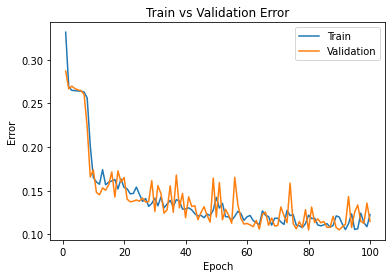

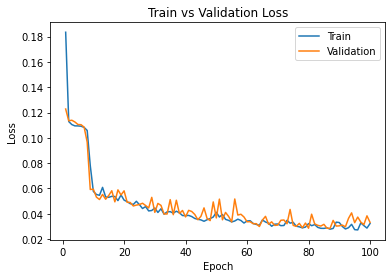

In [167]:
'''
More epochs
'''
# net = VAENetSmall("ASL_small", transfer_model=None, transfer_ftrs=1000)
net = VanillaVAE(3, 10)
net.name = "autoencoder"


batch = 64
lr = 0.1
m = 0.9
epochs = 100

train_network(net, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs, cuda=True)
model_path =  OUTPUT_DIR + get_model_name(net.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

torch.cuda.empty_cache()

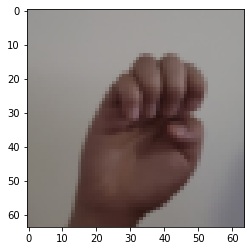

torch.Size([1, 3, 64, 64])


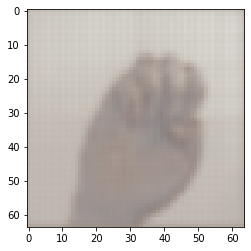

tensor([[[0.4887, 0.5218, 0.5448,  ..., 0.5518, 0.5355, 0.5001],
         [0.5089, 0.5632, 0.5911,  ..., 0.6194, 0.5945, 0.5369],
         [0.5304, 0.5899, 0.6174,  ..., 0.6609, 0.6343, 0.5636],
         ...,
         [0.4550, 0.4855, 0.4959,  ..., 0.4751, 0.4517, 0.4433],
         [0.4369, 0.4624, 0.4734,  ..., 0.4534, 0.4308, 0.4280],
         [0.4050, 0.3993, 0.4110,  ..., 0.3947, 0.3800, 0.3974]],

        [[0.4171, 0.4624, 0.4983,  ..., 0.5040, 0.4916, 0.4043],
         [0.4671, 0.5221, 0.5550,  ..., 0.5938, 0.5601, 0.4879],
         [0.4920, 0.5427, 0.5768,  ..., 0.6295, 0.6022, 0.5169],
         ...,
         [0.4021, 0.4290, 0.4379,  ..., 0.4235, 0.3857, 0.3757],
         [0.3801, 0.3820, 0.4010,  ..., 0.3772, 0.3595, 0.3504],
         [0.3040, 0.3208, 0.3325,  ..., 0.3194, 0.2960, 0.2951]],

        [[0.3527, 0.4039, 0.4340,  ..., 0.4462, 0.4257, 0.3596],
         [0.4100, 0.4726, 0.5021,  ..., 0.5465, 0.5053, 0.4259],
         [0.4274, 0.4902, 0.5195,  ..., 0.5794, 0.5434, 0.

In [168]:
train_dl, val_dl, _ = get_data_loaders(batch_size=1)

net.eval()
net = net.to('cpu')
count = 0
for data in train_dl:
    count += 1
    if count < 1:
        continue
    img, _, _ = data
    imshow(img[0])
    
    out = net(img)
    out = out[0].detach()
    print(out.shape)
    imshow(out[0])
    print(out[0])
    
    break